# Differentiable Ray Tracing of Geometry

Before running this notebook, please ensure Instant RM is installed by following the [instructions in the README](../README.md#Installation). We also recommend to start with the [Tutorial notebook](Tutorial.ipynb) to familiarize yourself with Instant RM fundamentals before diving into this notebook, focused on the optimization of the scene geometry through gradient descent.

This notebook illustrates how Instant RM enables the computation of gradients with respect to the scene geometry.

We consider a scene featuring a metal hemisphere with a radius of 1m, located at the origin.
Two radio emitters, a transmitter and an inteferer, as well as a radio map are placed as shown in the figure below.
Blocking screens are placed such that the line-of-sight (LoS) from both emitters to the radio map is blocked.
Note that some of the traced rays are visualized for clarity in this figure.

Then, a signal-to-interference (SIR) map is computed for the defined measurement plane as follows.
A path loss map is computed for each emitter, and the SIR for cell $k$ is defined as

$$
\text{SIR}_k = \frac{m_k}{\widetilde{m}_k}, ~1 \leq k \leq K
$$

where $K$ is the number of cells forming the SIR map, $\textbf{m} = \left[ m_1, \dots, m_K \right]$ is the path loss map of the transmitter, and $\widetilde{\textbf{m}} = \left[ \widetilde{m}_1, \dots, \widetilde{m}_K \right]$ the path loss map of the interferer.

![gt](img/diff_geometry_init.png)

Next, gradient descent is iteratively performed on the scaling of the hemisphere to maximize the average SIR

$$
\widehat{\text{SIR}} = \mathbb{E} \left[ \text{SIR}_k \right]
$$

where averaging is over all cells.
Note that the set of trainable parameters consists of three values, each serving as an individual scaling factor for the x, y, and z components.

A video demonstrating the experiment implemented in this notebook is available [here](https://drive.google.com/file/d/1_16xMYBlSa_kJlqoGusKk6iJAQRvBi47).

In [1]:
import numpy as np

import mitsuba as mi
import drjit as dr

%matplotlib inline
import matplotlib.pyplot as plt

from instant_rm import MapTracer

We start by loading the scene

In [2]:
scene = mi.load_file("../scenes/hemisphere/hemisphere.xml")
params = mi.traverse(scene)

Next, we define the transmitter, interferer, and measurement plane configuration, as well as the lower and upper bounds of the colorbar for plotting radio maps

In [3]:
# Transmitter and interferer configuration
tx_position = np.array([2.0, -1.0, -1.5]) # Transmitter position
it_position = np.array([-1.0, 2.0, -1.5]) # Interferer position
# Orientation and antenna configuration are shared by both the transmitter and the inteferer
tx_orientation = np.array([0.0, 0.0, 0.0])
tx_pattern = 'iso'
fc = 3.5e9
tx_slant_angle = 0.0

# Measurement plane configuration used for both the
# transmitter and inteferer
mp_center = np.array([2.0, 2.0, -2])
mp_orientation = np.array([0., 0., 0.])
mp_size = np.array([1., 1.])
mp_cell_size = np.array([0.1, 0.1])

# Upper and lower bound for the colormap used to visualize
# SIR maps [dB]
vmin = 0
vmax = 35

We then instantiate the tracer.
The same tracer is used for both the transmitter and the inteferer.

In [4]:
tracer = MapTracer(scene, fc, tx_pattern, tx_slant_angle,
                   mp_center, mp_orientation, mp_size, mp_cell_size,
                   num_samples=int(2e7), max_depth=1)

The next cell saves the initial location of the trainable reflector (hemisphere) vertices

In [5]:
initial_vertices = dr.detach(dr.unravel(mi.Point3f, params["mesh-Reflector.vertex_positions"]))

Then, a utility function that scales the initial vertices is defined.
This utility function effectively modifies the geometry of the reflector.

In [6]:
def transform_reflector(scale_x, scale_y, scale_z):
    vertices = mi.Point3f(initial_vertices)
    #
    vertices.x *= scale_x
    vertices.y *= scale_y
    vertices.z *= scale_z
    #
    params["mesh-Reflector.vertex_positions"] = dr.ravel(vertices)
    params.update();

The next cell defines a function that computes the SIR radio map, as well as an objective that consists in the average SIR, as stated at the beginning of this notebook

In [7]:
def compute_sir(pm_tx, pm_it):
    # Per-cell SIR
    sir = pm_tx/pm_it
    return sir

def compute_objective(pm_tx, pm_it):
    # SIR map
    sir_map = compute_sir(pm_tx, pm_it)
    # Average
    avg_sir = dr.mean(sir_map)
    return avg_sir

The following cell defines the parameters for iterative gradient descent, and instantiates the optimizer used for training

In [8]:
# Number of gradient descent iterations
num_iterations = 400

# Learning rate
lr = 2e-3

# Instantiate the optimizer
opt = mi.ad.Adam(lr=lr)

We now define and initialize the trainable scalings.
A trainable scaling factor is defined for each of the x, y, and z components.

In [9]:
scale_x_init = 1.0
scale_y_init = 1.0
scale_z_init = 1.0
opt["scale_x"] = mi.Float(scale_x_init)
opt["scale_y"] = mi.Float(scale_y_init)
opt["scale_z"] = mi.Float(scale_z_init)
#
transform_reflector(opt["scale_x"], opt["scale_y"], opt["scale_z"])

Let's plot and trace the initial SIR map

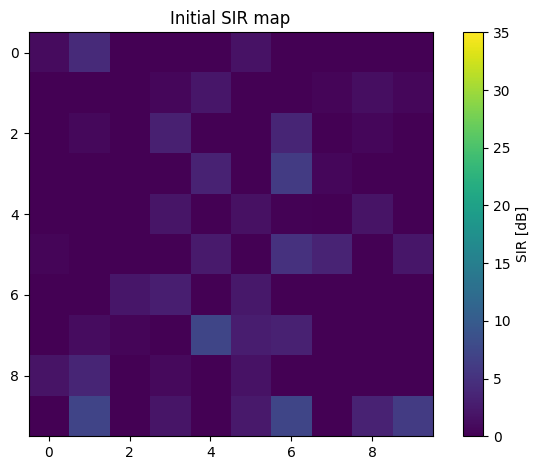

In [10]:
pm_tx, = tracer(tx_position, tx_orientation, rms_ds=False, mda=False, mdd=False, loop_record=False)
pm_it, = tracer(it_position, tx_orientation, rms_ds=False, mda=False, mdd=False, loop_record=False)
pm_tx = pm_tx.numpy()
pm_it = pm_it.numpy()
sir = compute_sir(pm_tx, pm_it)

# Display the initial SIR map
plt.figure()
plt.title("Initial SIR map")
plt.imshow(10.0*np.log10(sir), vmin=vmin, vmax=vmax)
plt.colorbar(label="SIR [dB]")
plt.tight_layout()

We are now ready to perform gradient descent on the geometry through optimization of the scaling factors

In [11]:
sirs = []
scales_x = []
scales_y = []
scales_z = []
for i in range(num_iterations):

    # Forward pass
    pm_tx, = tracer(tx_position=tx_position, tx_orientation=tx_orientation,
                 loop_record=False, rms_ds=False, mda=False, mdd=False)
    pm_it, = tracer(tx_position=it_position, tx_orientation=tx_orientation,
                 loop_record=False, rms_ds=False, mda=False, mdd=False)

    # Loss function is the negative of the objective function
    avg_sir = compute_objective(pm_tx, pm_it)
    loss = -avg_sir

    # Update the geometry
    scale_x, scale_y, scale_z = opt["scale_x"], opt["scale_y"], opt["scale_z"]
    transform_reflector(scale_x, scale_y, scale_z)

    # Log
    avg_sir = avg_sir.numpy()[0]
    sirs.append(avg_sir)
    #
    scale_x = scale_x.numpy()[0]
    scales_x.append(scale_x)
    #
    scale_y = scale_y.numpy()[0]
    scales_y.append(scale_y)
    #
    scale_z = scale_z.numpy()[0]
    scales_z.append(scale_z)

    # Backward pass
    dr.backward(loss)

    # Gradient descent step
    opt.step()

    msg = f"Iteration: {i} / {num_iterations}" +\
          f" ## SIR: {10.0*np.log10(avg_sir):.2f} dB" +\
          f" ## Scale X: {scale_x:.2f}" +\
          f" ## Scale Y: {scale_y:.2f}" +\
          f" ## Scale Z: {scale_z:.2f}"
    print(msg, end="\r")

Let's plot and trace the SIR map after optimization of the reflector

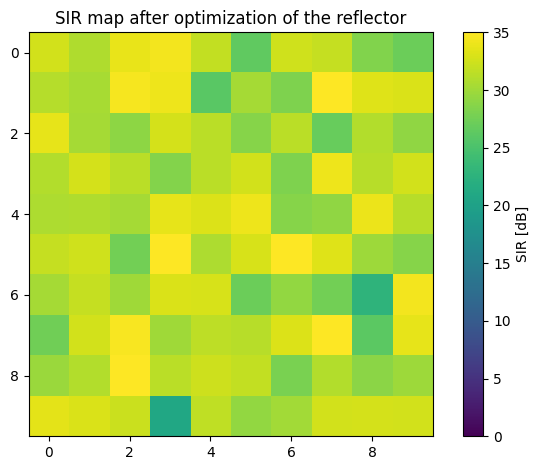

In [12]:
pm_tx, = tracer(tx_position, tx_orientation, rms_ds=False, mda=False, mdd=False, loop_record=False)
pm_it, = tracer(it_position, tx_orientation, rms_ds=False, mda=False, mdd=False, loop_record=False)
pm_tx = pm_tx.numpy()
pm_it = pm_it.numpy()
sir = compute_sir(pm_tx, pm_it)

# Display the SIR map after optimization
plt.figure()
plt.title("SIR map after optimization of the reflector")
plt.imshow(10.0*np.log10(sir), vmin=vmin, vmax=vmax)
plt.colorbar(label="SIR [dB]")
plt.tight_layout()

We visualize the average SIR and scaling factors as a function of the iteration index

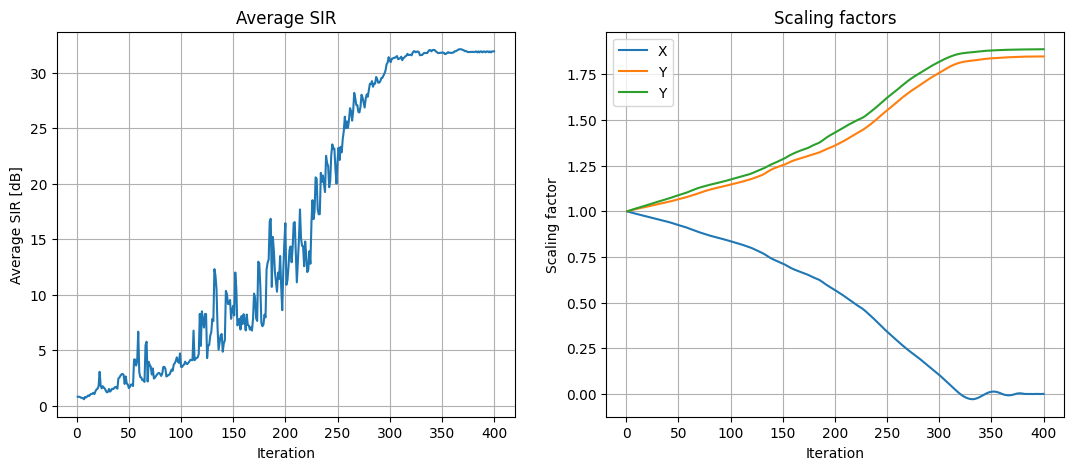

In [13]:
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,5))
# SIR
ax1.set_title("Average SIR")
ax1.plot(np.arange(1, num_iterations+1), 10.0*np.log10(sirs))
ax1.set_xlabel("Iteration")
ax1.set_ylabel("Average SIR [dB]")
ax1.grid(True)
# Scaling factors
ax2.set_title("Scaling factors")
ax2.plot(np.arange(1, num_iterations+1), scales_x, label="X")
ax2.plot(np.arange(1, num_iterations+1), scales_y, label="Y")
ax2.plot(np.arange(1, num_iterations+1), scales_z, label="Y")
ax2.set_xlabel("Iteration")
ax2.set_ylabel("Scaling factor")
ax2.grid(True)
ax2.legend();

The figure below shows the scene **after** optimization of the reflector shape to maximize the SIR.
The scaling with respect to the $x−$component has been squeezed to minimize the reception of radiation from the interferer, whereas the two other scaling factors have been increased to maximize the reception of radiation from the emitter.
Note that some of the traced rays are visualized for clarity in this figure.
A video demonstrating the experiment implemented in this notebook is available [here](https://drive.google.com/file/d/1_16xMYBlSa_kJlqoGusKk6iJAQRvBi47).

![gt](img/diff_geometry_opt.png)